In [1]:
'''bug, this version cariried out clippling with improper update method'''
'''fixed factor is normalizing the spectral density'''
'''the spectral density is computed separately along each axis'''
'''in this version we always use the same image (times batch size), 
substract batch average at each step to obtain batch-wise advantages
use reward with axes of fft being separated'''

'in this version we always use the same image (times batch size), \nsubstract batch average at each step to obtain batch-wise advantages\nuse reward with axes of fft being separated'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


config:  namespace(action_upper_bound=array([2., 2.]), batch_size=32, distance_penalty_coefficient=0.1, distance_penalty_enabled=False, distance_penalty_exponent=2, distance_penalty_r0=15.0, do_grayscale=True, filter=array([[[[ 0.        ],
         [ 1.        ],
         [ 0.93406058],
         [ 0.16910922],
         [-0.25916066],
         [-0.38278056],
         [-0.36833901],
         [-0.306479  ],
         [-0.23612829],
         [-0.17285442],
         [-0.12178184],
         [-0.08322866],
         [-0.05547789],
         [-0.03621425],
         [-0.02322227],
         [-0.01466442]]]]), fixed_image_num=1, fixed_spectral_density_normalization=1000000.0, foveate=None, gym_mode=False, history_length=16, image_h=224, image_hm=264, image_w=224, image_wm=264, loud=True, margin=20, max_freq=13, min_freq=1, motion_mode='velocity', normalize_spectral_density_per_step=False, sum_axes=False, t_ignore=16, t_max=50, use_dones=False)


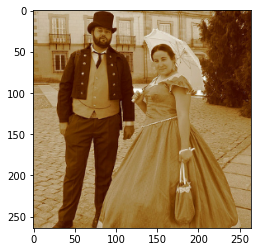

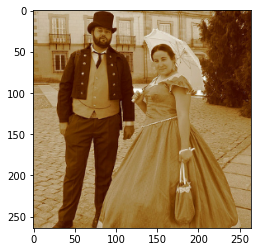

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.sum_axes = False
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.normalize_spectral_density_per_step = False
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model,do_clip=True)

In [ ]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards,log_probs = [], [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs, log_prob = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True, return_log_prob=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                log_probs=np.array(log_probs),
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -19.604599558265907
action means and variances at step -10: [0.23645383 0.00357609] [0.88387159 0.88145486]
action means and variances at step -5: [-0.06792943 -0.09877638] [0.99600266 0.96497129]
action statmeans and variances at step -10: [-0.0099762   0.04201149] [1. 1.]
action statmeans and variances at step -5: [-0.01289698  0.07338233] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -19.346904046865667
action means and variances at step -10: [ 0.04905881 -0.13326645] [1.20920803 0.75668982]
action means and variances at step -5: [-0.21498243 -0.1559233 ] [1.4922523  1.22541975]
action statmeans and variances at step -10: [-0.10418075  0.05435153] [1. 1.]
action statmeans and variances at step -5: [-0.11043774  0.06961782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -18.80071067967351
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -14.988666687270625
action means and variances at step -10: [-0.6258355  -0.45097403] [0.83503558 0.85155546]
action means and variances at step -5: [-0.61024414 -0.14291069] [1.03874178 0.77407376]
action statmeans and variances at step -10: [-0.88281316 -0.03830787] [1. 1.]
action statmeans and variances at step -5: [-0.8831793  -0.03935075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -14.40153148165774
action means and variances at step -10: [-0.87518939  0.05631178] [0.59001153 0.59401214]
action means and variances at step -5: [-9.74261179e-01  4.48114003e-04] [1.09796059 0.66874511]
action statmeans and variances at step -10: [-0.8846339 -0.1256366] [1. 1.]
action statmeans and variances at step -5: [-0.8870175  -0.11628228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -15.77026439600187
action means and va

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -14.762347206914955
action means and variances at step -10: [-1.11125163 -0.113195  ] [0.81214071 0.83615018]
action means and variances at step -5: [-1.59130396 -0.22605699] [0.64283882 0.8377152 ]
action statmeans and variances at step -10: [-1.2572701   0.03767971] [1. 1.]
action statmeans and variances at step -5: [-1.2611749   0.03442295] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -14.85487079215915
action means and variances at step -10: [-1.34485805 -0.16172025] [0.94696112 0.84614254]
action means and variances at step -5: [-1.08280043  0.01246802] [1.10372489 0.66865487]
action statmeans and variances at step -10: [-1.2679498  -0.01589414] [1. 1.]
action statmeans and variances at step -5: [-1.2716935  -0.01426194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -14.573648936546995
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -14.47714557037855
action means and variances at step -10: [-1.19978853 -0.17269161] [1.01310379 1.154936  ]
action means and variances at step -5: [-0.87646791 -0.24903739] [1.00047278 0.71828428]
action statmeans and variances at step -10: [-1.081431   -0.03735885] [1. 1.]
action statmeans and variances at step -5: [-1.0858424  -0.03415213] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -15.242845214061758
action means and variances at step -10: [-0.97776351  0.1330204 ] [0.93754026 1.22572912]
action means and variances at step -5: [-0.87911046 -0.10792463] [0.90341818 0.64589377]
action statmeans and variances at step -10: [-1.0806066  -0.05429904] [1. 1.]
action statmeans and variances at step -5: [-1.0779585 -0.0530623] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -14.680577518329876
action means and variances

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -15.169593271362686
action means and variances at step -10: [-1.52697048  0.50478779] [0.89975142 0.86591451]
action means and variances at step -5: [-1.23466231  0.18715887] [0.91937373 0.83809589]
action statmeans and variances at step -10: [-1.3591254   0.08572585] [1. 1.]
action statmeans and variances at step -5: [-1.3631188   0.08272971] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -14.479334866336336
action means and variances at step -10: [-1.64930635  0.24354903] [0.97091488 0.64445208]
action means and variances at step -5: [-1.10456069  0.02195095] [0.87799569 1.58971009]
action statmeans and variances at step -10: [-1.3506424   0.10564372] [1. 1.]
action statmeans and variances at step -5: [-1.3443357   0.10269179] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -14.727413103684551
action means and varian

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -15.4934864363956
action means and variances at step -10: [-1.40730659  0.3473951 ] [0.61128532 1.02797384]
action means and variances at step -5: [-1.13917898  0.09959135] [1.10087032 1.43488904]
action statmeans and variances at step -10: [-1.2921989   0.11292089] [1. 1.]
action statmeans and variances at step -5: [-1.2944267   0.12148294] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -15.4060892468556
action means and variances at step -10: [-1.39683895  0.30150403] [1.28159859 1.62649187]
action means and variances at step -5: [-1.25759723  0.46880274] [1.24551066 0.82399255]
action statmeans and variances at step -10: [-1.2687254   0.24105895] [1. 1.]
action statmeans and variances at step -5: [-1.266888  0.244009] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -15.601494972816477
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -14.223536146298173
action means and variances at step -10: [-1.93102502 -0.18606039] [0.7720961  0.72118575]
action means and variances at step -5: [-1.58074909  0.10322148] [1.22199136 1.28705527]
action statmeans and variances at step -10: [-1.6125915  -0.00979359] [1. 1.]
action statmeans and variances at step -5: [-1.6141165  -0.02113102] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -14.789152964904659
action means and variances at step -10: [-1.41239325 -0.0534467 ] [1.10479867 0.85233039]
action means and variances at step -5: [-1.66052678  0.29798337] [0.52410637 0.92033547]
action statmeans and variances at step -10: [-1.6501584   0.01644146] [1. 1.]
action statmeans and variances at step -5: [-1.6500127   0.02383599] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -14.794804805688697
action means and varian

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -14.329534469639771
action means and variances at step -10: [-1.71383382  0.02069856] [0.69155571 1.0791832 ]
action means and variances at step -5: [-1.77208271 -0.23781792] [1.00713864 0.92752876]
action statmeans and variances at step -10: [-1.6385589  -0.03691299] [1. 1.]
action statmeans and variances at step -5: [-1.6433864  -0.03511174] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -15.220277300837033
action means and variances at step -10: [-1.67888459 -0.18150004] [0.92717593 1.34338667]
action means and variances at step -5: [-2.0388161  -0.16637201] [1.02824375 0.66229983]
action statmeans and variances at step -10: [-1.6131388 -0.1425195] [1. 1.]
action statmeans and variances at step -5: [-1.6121378  -0.14083862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -15.258750825802709
action means and variance

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -15.215582998667108
action means and variances at step -10: [-2.12918389 -0.05218283] [0.94677048 0.92561758]
action means and variances at step -5: [-1.79762008  0.00383162] [1.00935086 0.94337851]
action statmeans and variances at step -10: [-1.9146463  -0.00934456] [1. 1.]
action statmeans and variances at step -5: [-1.9203393 -0.0054518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -15.76654834818479
action means and variances at step -10: [-1.95829735 -0.21790651] [0.77282696 1.34603745]
action means and variances at step -5: [-2.0741632   0.34515583] [0.87954121 0.65360719]
action statmeans and variances at step -10: [-1.9916086   0.06851459] [1. 1.]
action statmeans and variances at step -5: [-1.9899998   0.06626283] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -15.426282530226022
action means and variances

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -16.500281827209186
action means and variances at step -10: [-2.32218687  0.11075559] [0.85020315 1.40200516]
action means and variances at step -5: [-2.31816883  0.0359446 ] [1.20344019 1.50616725]
action statmeans and variances at step -10: [-2.198802   -0.12211742] [1. 1.]
action statmeans and variances at step -5: [-2.1983373  -0.12081839] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -16.74431607152801
action means and variances at step -10: [-2.20348398  0.09845524] [1.13783564 1.2604136 ]
action means and variances at step -5: [-1.89865075 -0.27214876] [1.07686679 0.77956653]
action statmeans and variances at step -10: [-2.1789937  -0.07688881] [1. 1.]
action statmeans and variances at step -5: [-2.1789382  -0.07340796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -15.508751889987467
action means and vari

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -16.281488296893283
action means and variances at step -10: [-2.04295111 -0.03789533] [0.98256321 1.05592335]
action means and variances at step -5: [-2.2656087   0.26483501] [0.7333036  0.84822369]
action statmeans and variances at step -10: [-2.3091273   0.08343993] [1. 1.]
action statmeans and variances at step -5: [-2.3100183   0.08501873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -17.918241887017516
action means and variances at step -10: [-2.5342238   0.09370902] [0.64650363 0.69875755]
action means and variances at step -5: [-2.17032154  0.25172454] [0.93532168 0.61957429]
action statmeans and variances at step -10: [-2.3819993  0.1438502] [1. 1.]
action statmeans and variances at step -5: [-2.3841348   0.15516798] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -17.29935514275609
action means and varian

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -17.778495961233922
action means and variances at step -10: [-2.80801481  0.12241976] [0.95190395 0.78000527]
action means and variances at step -5: [-2.31670717  0.25252412] [1.2956596  1.11420276]
action statmeans and variances at step -10: [-2.5095842  0.2930691] [1. 1.]
action statmeans and variances at step -5: [-2.5106597   0.29115766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -16.93414661905063
action means and variances at step -10: [-2.56954356  0.3203753 ] [0.89972297 0.91224239]
action means and variances at step -5: [-2.27996858  0.29020784] [0.98015546 1.27310207]
action statmeans and variances at step -10: [-2.520274    0.20264728] [1. 1.]
action statmeans and variances at step -5: [-2.5224254   0.20823316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -16.763995848782308
action means and varian

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -16.29629223821565
action means and variances at step -10: [-2.40151055 -0.08113639] [1.1852695  1.05757112]
action means and variances at step -5: [-2.41747121  0.22608767] [1.14737108 0.5288257 ]
action statmeans and variances at step -10: [-2.2772365   0.17097461] [1. 1.]
action statmeans and variances at step -5: [-2.2790549   0.18034643] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -16.22838098838217
action means and variances at step -10: [-2.31775842  0.13911979] [0.94688489 1.38998734]
action means and variances at step -5: [-2.07779363 -0.00583223] [0.92108674 1.13597534]
action statmeans and variances at step -10: [-2.3112228   0.10292989] [1. 1.]
action statmeans and variances at step -5: [-2.3108392   0.10430449] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -16.33064567460074
action means and varian

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -17.578603457242814
action means and variances at step -10: [-2.60700018 -0.03592747] [0.80249283 1.15440635]
action means and variances at step -5: [-2.65003678  0.0873283 ] [0.81644019 1.57433283]
action statmeans and variances at step -10: [-2.520792   0.0887773] [1. 1.]
action statmeans and variances at step -5: [-2.5221672   0.09266472] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -16.856351902579163
action means and variances at step -10: [-2.35170883  0.32524935] [1.17946534 0.90924492]
action means and variances at step -5: [-2.42415562  0.09224105] [0.90190382 0.79684977]
action statmeans and variances at step -10: [-2.4827447  0.0883114] [1. 1.]
action statmeans and variances at step -5: [-2.4818895   0.09392848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -16.572516493229145
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -16.595463383237167
action means and variances at step -10: [-2.27152384  0.33901759] [1.0744473  0.77124163]
action means and variances at step -5: [-2.55372317 -0.01198927] [0.88366369 1.20926925]
action statmeans and variances at step -10: [-2.323944    0.06698367] [1. 1.]
action statmeans and variances at step -5: [-2.3255818   0.07641725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -16.248471233117073
action means and variances at step -10: [-2.23675589  0.06502096] [1.47488512 0.93193288]
action means and variances at step -5: [-2.28717331  0.14117452] [0.84391443 1.09813797]
action statmeans and variances at step -10: [-2.2417057   0.12651058] [1. 1.]
action statmeans and variances at step -5: [-2.2441335   0.12820294] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -16.130587651812434
action means and var

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -14.643250389009136
action means and variances at step -10: [-2.15657751 -0.04048424] [0.80510054 0.74383583]
action means and variances at step -5: [-2.22579379  0.11177329] [0.84790465 0.64736814]
action statmeans and variances at step -10: [-2.158256    0.05212528] [1. 1.]
action statmeans and variances at step -5: [-2.158667    0.05765564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -16.44470725822301
action means and variances at step -10: [-2.2821699  0.182418 ] [0.97415194 0.85405158]
action means and variances at step -5: [-2.37386405 -0.06388582] [1.4971092 0.7572091]
action statmeans and variances at step -10: [-2.1697001   0.08584508] [1. 1.]
action statmeans and variances at step -5: [-2.1731372   0.07583762] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -15.551558534943211
action means and variance

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -16.47218739570931
action means and variances at step -10: [-2.27808995 -0.05099209] [0.64640837 1.03807099]
action means and variances at step -5: [-2.07025515  0.50305982] [0.6650641 0.9069692]
action statmeans and variances at step -10: [-2.170274    0.04812441] [1. 1.]
action statmeans and variances at step -5: [-2.1758964  0.0556443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -16.435099443089232
action means and variances at step -10: [-2.23185175  0.23508464] [0.87921342 0.68434564]
action means and variances at step -5: [-1.96094424 -0.19002767] [1.04962754 0.80093193]
action statmeans and variances at step -10: [-2.133679    0.06940574] [1. 1.]
action statmeans and variances at step -5: [-2.1344      0.07855789] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -16.105902869591517
action means and variance

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -16.325726644788546
action means and variances at step -10: [-2.24130381 -0.21968953] [1.36804811 1.48905415]
action means and variances at step -5: [-2.39994567 -0.17316373] [1.22199469 0.8233061 ]
action statmeans and variances at step -10: [-2.3480392  -0.02468361] [1. 1.]
action statmeans and variances at step -5: [-2.3490772  -0.02199698] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -17.51921551420538
action means and variances at step -10: [-2.76802505 -0.10998167] [1.0271098  0.62491369]
action means and variances at step -5: [-2.22297507  0.06673756] [0.81873525 0.95348418]
action statmeans and variances at step -10: [-2.3467836  -0.04488728] [1. 1.]
action statmeans and variances at step -5: [-2.3487859  -0.03690848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -16.466983888438286
action means and vari

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -16.43485841985097
action means and variances at step -10: [-2.42226598  0.1814459 ] [0.60577137 1.41294446]
action means and variances at step -5: [-2.02795657  0.33921174] [1.07696954 1.12465564]
action statmeans and variances at step -10: [-2.3474107  -0.04446737] [1. 1.]
action statmeans and variances at step -5: [-2.3501735  -0.03761494] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -16.912045813967516
action means and variances at step -10: [-2.45948931  0.08135716] [1.13888354 0.74368819]
action means and variances at step -5: [-2.45069925  0.14141436] [1.1722246  1.27030156]
action statmeans and variances at step -10: [-2.3494492  -0.00320018] [1. 1.]
action statmeans and variances at step -5: [-2.3503702e+00 -1.0800317e-03] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -15.968622968718083
action means an

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -16.632464925695526
action means and variances at step -10: [-2.17771822  0.04524372] [0.91695095 0.8236231 ]
action means and variances at step -5: [-2.36623443 -0.05156697] [0.53585168 1.19606894]
action statmeans and variances at step -10: [-2.3790398   0.02963221] [1. 1.]
action statmeans and variances at step -5: [-2.3789911   0.04253974] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -16.3278647468591
action means and variances at step -10: [-2.22872593 -0.2870097 ] [0.85204473 0.67724403]
action means and variances at step -5: [-2.29485999  0.09447877] [0.94546252 0.68164117]
action statmeans and variances at step -10: [-2.3450465  -0.06290621] [1. 1.]
action statmeans and variances at step -5: [-2.344551   -0.06467855] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -15.845983814382176
action means and varia

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -15.523757084446478
action means and variances at step -10: [-2.2013114   0.50208535] [0.50832759 1.32808474]
action means and variances at step -5: [-2.08838581 -0.08859534] [1.00124062 0.71216549]
action statmeans and variances at step -10: [-2.147977    0.12811369] [1. 1.]
action statmeans and variances at step -5: [-2.151493    0.14348562] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -14.73888750440178
action means and variances at step -10: [-2.29285813  0.28621786] [0.98559408 0.51914877]
action means and variances at step -5: [-2.12081221  0.10391056] [0.89901376 0.89952147]
action statmeans and variances at step -10: [-2.06954     0.08303533] [1. 1.]
action statmeans and variances at step -5: [-2.0741076   0.10062174] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -15.611530292944064
action means and vari

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -15.49649411061501
action means and variances at step -10: [-1.91304315  0.20523759] [0.96661482 1.01309312]
action means and variances at step -5: [-2.00188849 -0.01411015] [1.1118876  1.11462226]
action statmeans and variances at step -10: [-1.8387492   0.03847061] [1. 1.]
action statmeans and variances at step -5: [-1.84723     0.08202749] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -15.988118222779098
action means and variances at step -10: [-1.99779912  0.09297654] [0.87976307 1.19757691]
action means and variances at step -5: [-2.13215481 -0.01810743] [1.04499045 1.03783713]
action statmeans and variances at step -10: [-1.9370266  -0.00734229] [1. 1.]
action statmeans and variances at step -5: [-1.9442363  -0.01420235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -15.784332422153998
action means and vari

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -15.746290646729056
action means and variances at step -10: [-2.53978252 -0.12062563] [1.13639584 1.049993  ]
action means and variances at step -5: [-2.36697151  0.16876714] [1.06291566 0.85815472]
action statmeans and variances at step -10: [-2.2961473   0.12923598] [1. 1.]
action statmeans and variances at step -5: [-2.2996697   0.13581342] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -16.979446003493294
action means and variances at step -10: [-2.12684006  0.02538772] [0.85232183 1.12872267]
action means and variances at step -5: [-2.46147573e+00  1.29696702e-04] [1.17471898 0.88858789]
action statmeans and variances at step -10: [-2.321779    0.06316538] [1. 1.]
action statmeans and variances at step -5: [-2.320972    0.06367411] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -16.91547827732701
action means 

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -17.277750532625177
action means and variances at step -10: [-2.38408063 -0.04805104] [0.76742187 0.83234305]
action means and variances at step -5: [-2.21688733 -0.13216757] [0.80410893 1.07237344]
action statmeans and variances at step -10: [-2.3742065  -0.02694795] [1. 1.]
action statmeans and variances at step -5: [-2.370813   -0.03676097] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -16.911479754104747
action means and variances at step -10: [-2.28481526  0.00348561] [0.98156063 1.08352648]
action means and variances at step -5: [-2.40538889  0.29985825] [1.14311582 0.77568184]
action statmeans and variances at step -10: [-2.4135017  -0.05011386] [1. 1.]
action statmeans and variances at step -5: [-2.4188952  -0.02751446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -17.160359595984158
action means and var

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -16.48324853851531
action means and variances at step -10: [-2.56478208  0.20869886] [0.93180599 0.76522736]
action means and variances at step -5: [-2.27715092  0.12104069] [0.7107436 0.5423527]
action statmeans and variances at step -10: [-2.4139433   0.10897116] [1. 1.]
action statmeans and variances at step -5: [-2.4098215   0.09759663] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -16.77424210291318
action means and variances at step -10: [-2.23656437 -0.06203079] [0.86703782 0.92573336]
action means and variances at step -5: [-2.41082386  0.07479421] [0.7105828  0.94401665]
action statmeans and variances at step -10: [-2.403565    0.20360912] [1. 1.]
action statmeans and variances at step -5: [-2.3996491   0.18217601] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -17.10677115591516
action means and variance

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -17.357522865298193
action means and variances at step -10: [-2.72168928  0.15822842] [1.07728735 0.86498558]
action means and variances at step -5: [-2.56624786 -0.19411078] [1.31301212 0.94823167]
action statmeans and variances at step -10: [-2.5915189   0.03760231] [1. 1.]
action statmeans and variances at step -5: [-2.5917468   0.03006354] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -17.677680336288724
action means and variances at step -10: [-2.53606534  0.08627353] [0.91291465 0.55541542]
action means and variances at step -5: [-2.49244279 -0.11511246] [1.06062855 0.66387512]
action statmeans and variances at step -10: [-2.5926318   0.08861922] [1. 1.]
action statmeans and variances at step -5: [-2.5916967   0.08316289] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -17.39935898720413
action means and vari

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -15.340138099636182
action means and variances at step -10: [-2.2241369  -0.06773382] [0.71410967 1.13395467]
action means and variances at step -5: [-2.25616069  0.0358241 ] [0.89201143 0.93638901]
action statmeans and variances at step -10: [-2.2269874  0.1665562] [1. 1.]
action statmeans and variances at step -5: [-2.2327647   0.18398194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -16.43900060982049
action means and variances at step -10: [-2.20285332  0.19665573] [1.27829548 1.02124322]
action means and variances at step -5: [-1.91543595  0.13710745] [0.78767583 1.31600691]
action statmeans and variances at step -10: [-2.1838827   0.12002024] [1. 1.]
action statmeans and variances at step -5: [-2.1860147   0.12240048] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -16.28769169229256
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -13.746313693544245
action means and variances at step -10: [-1.80838757  0.08786639] [0.8989781  0.86392578]
action means and variances at step -5: [-2.08600293  0.13321595] [0.77211421 0.81423446]
action statmeans and variances at step -10: [-1.8874748   0.13260162] [1. 1.]
action statmeans and variances at step -5: [-1.8945451   0.11875802] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -14.7820392199561
action means and variances at step -10: [-2.20103237  0.01905194] [1.10657606 0.99926878]
action means and variances at step -5: [-1.85976471  0.45103537] [0.75374014 1.25405712]
action statmeans and variances at step -10: [-2.0192893   0.18144782] [1. 1.]
action statmeans and variances at step -5: [-2.0158849   0.14997631] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -15.603986258750632
action means and varia

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -15.12306525931387
action means and variances at step -10: [-2.13565023  0.16940847] [0.70923357 1.21869692]
action means and variances at step -5: [-1.92322118  0.0020861 ] [0.93743538 0.95063392]
action statmeans and variances at step -10: [-2.0630896  -0.02740379] [1. 1.]
action statmeans and variances at step -5: [-2.069489   -0.01227725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -14.387764755860484
action means and variances at step -10: [-1.97004339  0.11304153] [1.00747997 0.78952253]
action means and variances at step -5: [-2.14494342 -0.05471867] [0.65355497 0.70306072]
action statmeans and variances at step -10: [-2.0435631   0.03805718] [1. 1.]
action statmeans and variances at step -5: [-2.0470066   0.01108769] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -15.409145282631133
action means and vari

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -15.272296287311448
action means and variances at step -10: [-2.21123453  0.142988  ] [1.04801371 0.90472822]
action means and variances at step -5: [-1.99946543 -0.38431384] [0.95792176 0.9822088 ]
action statmeans and variances at step -10: [-2.0985298e+00  1.2003488e-03] [1. 1.]
action statmeans and variances at step -5: [-2.0863106  -0.04723514] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -15.898045811546282
action means and variances at step -10: [-2.18648139  0.03620807] [1.00522034 1.05233094]
action means and variances at step -5: [-2.14676806 -0.06926385] [1.00088691 1.31289248]
action statmeans and variances at step -10: [-2.1265483  -0.01544212] [1. 1.]
action statmeans and variances at step -5: [-2.125982   -0.02989526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -14.861084446408764
action means a

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -15.289304173584336
action means and variances at step -10: [-1.77559181 -0.16146249] [0.89410403 1.207861  ]
action means and variances at step -5: [-1.99565265  0.11610416] [1.05982495 0.89565824]
action statmeans and variances at step -10: [-1.9657204   0.04354692] [1. 1.]
action statmeans and variances at step -5: [-1.941159   -0.07389636] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -15.898293338687406
action means and variances at step -10: [-1.98206931  0.07520934] [0.86463361 0.91354009]
action means and variances at step -5: [-2.01302632 -0.0438995 ] [1.22267599 1.06986806]
action statmeans and variances at step -10: [-2.056018  -0.0201872] [1. 1.]
action statmeans and variances at step -5: [-2.045934   -0.06486584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -14.755364593826084
action means and varia

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -14.767175774536858
action means and variances at step -10: [-2.22256503 -0.02232187] [0.91674474 1.16439525]
action means and variances at step -5: [-2.11677404 -0.0576768 ] [1.3616086  0.72465625]
action statmeans and variances at step -10: [-2.0664668   0.22272664] [1. 1.]
action statmeans and variances at step -5: [-2.0702226   0.22624514] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -15.341636530056796
action means and variances at step -10: [-2.25166946  0.1375581 ] [0.72127355 0.54204716]
action means and variances at step -5: [-2.07459688  0.33180495] [1.15807407 0.92757385]
action statmeans and variances at step -10: [-2.067818    0.16051057] [1. 1.]
action statmeans and variances at step -5: [-2.0771694   0.19109778] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -15.773262455365742
action means and var

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -14.572863935784625
action means and variances at step -10: [-1.87943829 -0.12010346] [0.57467778 1.11121742]
action means and variances at step -5: [-1.87448448  0.11615313] [0.6044636  1.14306654]
action statmeans and variances at step -10: [-1.9276779 -0.1048267] [1. 1.]
action statmeans and variances at step -5: [-1.9330425  -0.08287987] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -15.800567248937273
action means and variances at step -10: [-1.95807486  0.04312275] [0.62747805 0.65403077]
action means and variances at step -5: [-2.63113772 -0.18634866] [1.02518302 0.84151605]
action statmeans and variances at step -10: [-1.930229   -0.09494194] [1. 1.]
action statmeans and variances at step -5: [-1.9282911  -0.14970781] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -14.882951617676966
action means and varia

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -15.069976964543699
action means and variances at step -10: [-2.19540997 -0.02459126] [1.03152803 1.2362972 ]
action means and variances at step -5: [-2.41980743 -0.2918852 ] [0.99600153 0.89186586]
action statmeans and variances at step -10: [-2.1996608  -0.05346247] [1. 1.]
action statmeans and variances at step -5: [-2.2100277   0.05826499] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -15.677198025665685
action means and variances at step -10: [-2.10047103  0.40329208] [0.88145746 0.74086399]
action means and variances at step -5: [-2.29533713 -0.25592349] [1.27215629 0.87894459]
action statmeans and variances at step -10: [-2.2817581e+00  2.2535382e-03] [1. 1.]
action statmeans and variances at step -5: [-2.2805939  -0.02187889] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -15.263936023008597
action means a

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -15.994850834527874
action means and variances at step -10: [-2.36844914  0.39995563] [1.2480012  1.49293038]
action means and variances at step -5: [-2.77837981  0.02341554] [1.15742254 0.72103609]
action statmeans and variances at step -10: [-2.405334    0.01772129] [1. 1.]
action statmeans and variances at step -5: [-2.4024558 -0.0336909] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -15.651861168424885
action means and variances at step -10: [-2.56465643  0.18776852] [0.86446423 1.18415047]
action means and variances at step -5: [-2.30357367  0.23198356] [0.89161316 0.91179255]
action statmeans and variances at step -10: [-2.3766723   0.08743582] [1. 1.]
action statmeans and variances at step -5: [-2.3857818  0.1655568] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -15.985887848665135
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -15.827662700321339
action means and variances at step -10: [-2.13421764 -0.11634335] [0.89317118 0.70265984]
action means and variances at step -5: [-2.51332016  0.23335589] [0.84848279 1.68880178]
action statmeans and variances at step -10: [-2.4855752   0.11174108] [1. 1.]
action statmeans and variances at step -5: [-2.4857078   0.07165407] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -15.61662151949584
action means and variances at step -10: [-1.92802433  0.10828224] [0.82533126 0.76108695]
action means and variances at step -5: [-2.3920885  -0.08855226] [0.75414145 1.09819428]
action statmeans and variances at step -10: [-2.4659724  -0.08270799] [1. 1.]
action statmeans and variances at step -5: [-2.4759128 -0.0328146] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -15.69567816425274
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -16.111534894948853
action means and variances at step -10: [-2.5018339 -0.1486966] [1.31025421 0.83772953]
action means and variances at step -5: [-2.1975748   0.27382362] [0.50145129 0.90765588]
action statmeans and variances at step -10: [-2.298909   -0.01010838] [1. 1.]
action statmeans and variances at step -5: [-2.2975936e+00 -6.5175846e-04] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -15.406087803008297
action means and variances at step -10: [-2.10722712  0.50663781] [0.85287309 0.84166487]
action means and variances at step -5: [-2.31102754  0.32141245] [0.64542592 0.88222014]
action statmeans and variances at step -10: [-2.316384   -0.00322923] [1. 1.]
action statmeans and variances at step -5: [-2.3264601   0.05435989] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -15.664301076179944
action means and

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -15.11328965538477
action means and variances at step -10: [-2.1111131  -0.08071671] [0.81637181 1.20867504]
action means and variances at step -5: [-2.31993809  0.12860297] [0.65981725 1.19821648]
action statmeans and variances at step -10: [-2.218281   -0.10999101] [1. 1.]
action statmeans and variances at step -5: [-2.2273912  -0.04097216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -14.86112272099868
action means and variances at step -10: [-2.34449132  0.13440639] [0.84515508 0.935553  ]
action means and variances at step -5: [-1.99412357 -0.00651616] [0.85829106 1.2012977 ]
action statmeans and variances at step -10: [-2.2075186   0.09262793] [1. 1.]
action statmeans and variances at step -5: [-2.205698    0.01286608] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -15.677002445998077
action means and varia

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -14.693239978658276
action means and variances at step -10: [-2.18694908  0.0933245 ] [1.11705086 1.07341528]
action means and variances at step -5: [-1.79673287  0.15259186] [1.47366787 0.60951155]
action statmeans and variances at step -10: [-1.9855446  -0.03281687] [1. 1.]
action statmeans and variances at step -5: [-1.9735317  -0.19391061] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -14.45964308017904
action means and variances at step -10: [-2.15096723 -0.12968885] [0.85544125 1.2276087 ]
action means and variances at step -5: [-1.91402459 -0.25400904] [1.22403387 1.22061275]
action statmeans and variances at step -10: [-1.9714301   0.13477097] [1. 1.]
action statmeans and variances at step -5: [-1.9693282   0.10647517] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -14.456610602804945
action means and vari

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -15.474132545861162
action means and variances at step -10: [-2.25450908  0.3541204 ] [1.22762495 0.83640373]
action means and variances at step -5: [-2.29337533 -0.04942314] [0.89694923 1.61833608]
action statmeans and variances at step -10: [-2.2482736  0.1003542] [1. 1.]
action statmeans and variances at step -5: [-2.23967    0.0040949] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -15.004526915984087
action means and variances at step -10: [-2.45823519 -0.03305057] [0.41804947 1.10852608]
action means and variances at step -5: [-2.43477419  0.13538773] [1.36944882 1.25016461]
action statmeans and variances at step -10: [-2.3178596   0.19771594] [1. 1.]
action statmeans and variances at step -5: [-2.3002565   0.01664945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -15.968081507951196
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -16.55781204628417
action means and variances at step -10: [-2.61651955  0.1002089 ] [1.28854707 1.21483309]
action means and variances at step -5: [-2.57291381  0.14231939] [1.00770778 1.17985249]
action statmeans and variances at step -10: [-2.5772562   0.02431182] [1. 1.]
action statmeans and variances at step -5: [-2.5749245  -0.01668776] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -16.17730427884447
action means and variances at step -10: [-3.00757774 -0.23282707] [1.0008853  0.89758119]
action means and variances at step -5: [-2.62779667 -0.01474011] [0.85352969 0.70194091]
action statmeans and variances at step -10: [-2.6134048   0.08686732] [1. 1.]
action statmeans and variances at step -5: [-2.6086915e+00  1.0464670e-03] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -15.62764238893396
action means and 

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -16.627245727050138
action means and variances at step -10: [-2.62771213  0.3442606 ] [1.23867447 0.92022454]
action means and variances at step -5: [-2.54779836  0.28425241] [1.3495292  0.65279514]
action statmeans and variances at step -10: [-2.546467    0.28017724] [1. 1.]
action statmeans and variances at step -5: [-2.540985    0.18623722] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -15.526120911308798
action means and variances at step -10: [-2.39905804  0.10094631] [1.33344794 1.09769424]
action means and variances at step -5: [-2.86718375 -0.03666769] [1.03760659 1.16677452]
action statmeans and variances at step -10: [-2.5115888  -0.03540463] [1. 1.]
action statmeans and variances at step -5: [-2.5161848  0.2042681] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -15.587175836281775
action means and varia

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -16.19769153889618
action means and variances at step -10: [-2.4022007   0.33385253] [1.2759453 0.8477431]
action means and variances at step -5: [-2.58553614  0.16098051] [0.94778172 1.05427933]
action statmeans and variances at step -10: [-2.4827096  -0.04649642] [1. 1.]
action statmeans and variances at step -5: [-2.47648    -0.03274374] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -16.278947249986327
action means and variances at step -10: [-2.58817865 -0.08132438] [0.58616348 0.946457  ]
action means and variances at step -5: [-2.1705835   0.15546214] [0.79916723 0.56559783]
action statmeans and variances at step -10: [-2.4464912   0.07112519] [1. 1.]
action statmeans and variances at step -5: [-2.4439454  0.0230827] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -16.37196125356224
action means and variances

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -16.40348650771544
action means and variances at step -10: [-2.50182039  0.14772585] [0.74769944 0.93609931]
action means and variances at step -5: [-2.79972569  0.0565482 ] [0.75967604 0.70289879]
action statmeans and variances at step -10: [-2.5720725   0.15888068] [1. 1.]
action statmeans and variances at step -5: [-2.5733352   0.13765094] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -15.794110096142456
action means and variances at step -10: [-2.48882534  0.08305873] [0.87122656 0.67438435]
action means and variances at step -5: [-2.51291967  0.06934002] [0.85053187 1.35771895]
action statmeans and variances at step -10: [-2.600603   0.1137429] [1. 1.]
action statmeans and variances at step -5: [-2.592453   -0.06337868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -15.951261808716293
action means and varian

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -16.861499872259007
action means and variances at step -10: [-3.17887576 -0.57090534] [0.74683756 1.34431896]
action means and variances at step -5: [-2.81388761 -0.07760575] [0.94124618 0.46411535]
action statmeans and variances at step -10: [-2.7642522   0.01379261] [1. 1.]
action statmeans and variances at step -5: [-2.7644548   0.08863169] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -16.470811383004737
action means and variances at step -10: [-2.93266386  0.2046138 ] [0.95449379 0.61483155]
action means and variances at step -5: [-2.67826522  0.06080055] [0.59688467 0.88869929]
action statmeans and variances at step -10: [-2.7546468   0.01555016] [1. 1.]
action statmeans and variances at step -5: [-2.7505882   0.00585315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -16.5077114820402
action means and varia

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -16.02389294546439
action means and variances at step -10: [-2.50270102  0.38665698] [1.0677494  0.72138696]
action means and variances at step -5: [-2.71859889 -0.06965369] [0.87945818 0.95895658]
action statmeans and variances at step -10: [-2.6890912   0.25576907] [1. 1.]
action statmeans and variances at step -5: [-2.6703353   0.09024286] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -16.84601060566443
action means and variances at step -10: [-2.69853806  0.50970075] [1.40018522 1.29364389]
action means and variances at step -5: [-2.57111291  0.45377017] [0.76614108 0.86332462]
action statmeans and variances at step -10: [-2.6761377   0.31720415] [1. 1.]
action statmeans and variances at step -5: [-2.6616063   0.19069234] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -16.362462517372883
action means and varia

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -15.81180036930959
action means and variances at step -10: [-2.32922914 -0.08768814] [1.00178757 0.82937447]
action means and variances at step -5: [-2.68606579  0.40065813] [1.07794297 0.74572094]
action statmeans and variances at step -10: [-2.6431286   0.15001321] [1. 1.]
action statmeans and variances at step -5: [-2.6317     -0.01608004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -16.255480990391156
action means and variances at step -10: [-3.02348178 -0.1116709 ] [1.11144792 1.073541  ]
action means and variances at step -5: [-2.77089083  0.29766297] [0.80384431 0.83275966]
action statmeans and variances at step -10: [-2.6509824   0.08302224] [1. 1.]
action statmeans and variances at step -5: [-2.6455188   0.04228834] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -16.209686867972827
action means and vari

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -15.406462511491547
action means and variances at step -10: [-2.85913233  0.23410565] [1.06329635 0.75459858]
action means and variances at step -5: [-2.27987438  0.24300604] [1.06498202 1.13928224]
action statmeans and variances at step -10: [-2.5211093  -0.03999784] [1. 1.]
action statmeans and variances at step -5: [-2.5086505  0.0579659] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -15.626624691626205
action means and variances at step -10: [-2.68656066  0.11607224] [0.86372704 1.05006839]
action means and variances at step -5: [-2.42078557  0.01867648] [1.16138583 1.19064192]
action statmeans and variances at step -10: [-2.4990914  -0.10387268] [1. 1.]
action statmeans and variances at step -5: [-2.4986587   0.06140076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -15.844897267097563
action means and varia

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -14.95646161751792
action means and variances at step -10: [-2.19863721 -0.22789126] [0.81341658 1.34175585]
action means and variances at step -5: [-2.53735794  0.14580211] [1.31185369 1.6720604 ]
action statmeans and variances at step -10: [-2.4225686  -0.00798815] [1. 1.]
action statmeans and variances at step -5: [-2.41292    -0.25313032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -15.583744398413844
action means and variances at step -10: [-2.39771082  0.02008722] [0.80020311 1.15254259]
action means and variances at step -5: [-2.6472336  -0.07102659] [0.54990853 1.44263424]
action statmeans and variances at step -10: [-2.4274662  -0.01550667] [1. 1.]
action statmeans and variances at step -5: [-2.4336467  -0.07684532] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -15.186501557904862
action means and vari

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -15.105623326501199
action means and variances at step -10: [-2.50825867 -0.22121079] [1.35014714 0.91356589]
action means and variances at step -5: [-2.5259061  -0.12256702] [0.9096939  1.17741399]
action statmeans and variances at step -10: [-2.4894557  -0.13685402] [1. 1.]
action statmeans and variances at step -5: [-2.4879076 -0.0551048] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -15.605553523364687
action means and variances at step -10: [-2.44653744  0.3919266 ] [0.72367538 1.03444238]
action means and variances at step -5: [-2.63002976 -0.2091801 ] [1.02643656 1.20845461]
action statmeans and variances at step -10: [-2.4997365 -0.2789734] [1. 1.]
action statmeans and variances at step -5: [-2.5070953   0.05201234] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -15.5965941944692
action means and variances

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -16.61006325114725
action means and variances at step -10: [-2.7004828  -0.15683507] [1.82256167 0.83264663]
action means and variances at step -5: [-2.53312638 -0.09702501] [0.976926   0.62013125]
action statmeans and variances at step -10: [-2.6315496  0.0463651] [1. 1.]
action statmeans and variances at step -5: [-2.6163344   0.18322852] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -16.148027987652767
action means and variances at step -10: [-2.82005627  0.17235776] [0.61637191 0.99495069]
action means and variances at step -5: [-2.57482742 -0.22072028] [1.02253213 0.71170896]
action statmeans and variances at step -10: [-2.6380455  -0.02345627] [1. 1.]
action statmeans and variances at step -5: [-2.6332223  -0.03191613] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -15.609710031801843
action means and varian

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -15.594033618609043
action means and variances at step -10: [-2.83040964 -0.12791169] [0.74459753 0.57253034]
action means and variances at step -5: [-2.47137859 -0.29514599] [0.85883539 0.87142586]
action statmeans and variances at step -10: [-2.5767899  -0.36320543] [1. 1.]
action statmeans and variances at step -5: [-2.5668523  -0.29881382] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -15.495908632923415
action means and variances at step -10: [-2.62164696  0.12254583] [0.95399828 0.67082939]
action means and variances at step -5: [-2.42411456 -0.26360865] [0.71783817 0.92449229]
action statmeans and variances at step -10: [-2.5022538   0.13331005] [1. 1.]
action statmeans and variances at step -5: [-2.4997187   0.35124588] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -15.5537450857731
action means and varia

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -14.786445756136196
action means and variances at step -10: [-2.30857514 -0.51796207] [0.75868938 0.77693654]
action means and variances at step -5: [-2.49899814 -0.12044073] [0.88704278 0.75794894]
action statmeans and variances at step -10: [-2.3438232  -0.32390797] [1. 1.]
action statmeans and variances at step -5: [-2.3548543   0.18838495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -14.61196348041042
action means and variances at step -10: [-2.30728478 -0.14820995] [0.79537872 1.19725402]
action means and variances at step -5: [-2.44936894 -0.3048256 ] [1.0509089  0.99779128]
action statmeans and variances at step -10: [-2.40871   -0.2866751] [1. 1.]
action statmeans and variances at step -5: [-2.3963764 -0.1564641] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -15.092254196185525
action means and variance

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -14.98575475887736
action means and variances at step -10: [-2.53293767 -0.10834415] [0.63349808 0.96711411]
action means and variances at step -5: [-2.37160647  0.05392708] [0.72953738 0.7038324 ]
action statmeans and variances at step -10: [-2.421297   -0.06172977] [1. 1.]
action statmeans and variances at step -5: [-2.4212644 -0.1412516] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -15.642808843387552
action means and variances at step -10: [-2.47744674  0.11758306] [0.77250155 1.39882792]
action means and variances at step -5: [-2.51016743 -0.11680095] [1.10676152 0.92546632]
action statmeans and variances at step -10: [-2.3962052  -0.48534402] [1. 1.]
action statmeans and variances at step -5: [-2.4106255   0.31443217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -16.25631636710417
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -14.515175467895745
action means and variances at step -10: [-2.47253892 -0.01396436] [0.87148061 1.06848642]
action means and variances at step -5: [-2.43193172  0.03266793] [0.77603951 0.6170137 ]
action statmeans and variances at step -10: [-2.4335196   0.69945836] [1. 1.]
action statmeans and variances at step -5: [-2.4001627   0.05166107] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -14.938726184245919
action means and variances at step -10: [-2.41998058 -0.22490658] [1.13431535 0.79131832]
action means and variances at step -5: [-2.53296287  0.00865388] [1.01210002 1.29553954]
action statmeans and variances at step -10: [-2.3840826   0.21610028] [1. 1.]
action statmeans and variances at step -5: [-2.3829966   0.15386927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -15.020365016503678
action means and var

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -16.071703302770544
action means and variances at step -10: [-2.45172984 -0.22347805] [1.02519383 1.12122705]
action means and variances at step -5: [-2.17910671  0.11244227] [0.82612858 0.98327043]
action statmeans and variances at step -10: [-2.354224    0.09480963] [1. 1.]
action statmeans and variances at step -5: [-2.348634    0.01315925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -15.723853000223947
action means and variances at step -10: [-2.43669432 -0.17803973] [0.98457335 0.87514379]
action means and variances at step -5: [-2.28207667  0.19115356] [0.9127426  0.93034254]
action statmeans and variances at step -10: [-2.2864962  -0.58983994] [1. 1.]
action statmeans and variances at step -5: [-2.3078423  -0.10131653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -16.206143919341507
action means and var

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -14.655841660416645
action means and variances at step -10: [-2.2155039   0.09546077] [0.5737087  1.04281158]
action means and variances at step -5: [-2.4273731   0.05270615] [0.71990158 0.92174596]
action statmeans and variances at step -10: [-2.2729084  -0.15653978] [1. 1.]
action statmeans and variances at step -5: [-2.2707078   0.02155569] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -14.838780295302943
action means and variances at step -10: [-2.15485028  0.06540885] [0.98649337 1.84153462]
action means and variances at step -5: [-2.50626928 -0.26665756] [0.62515706 1.03228761]
action statmeans and variances at step -10: [-2.2794857  -0.60760987] [1. 1.]
action statmeans and variances at step -5: [-2.287421   -0.25169066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -14.861486388086208
action means and var

Training for 17 iterations with batchsize 64
Episode * 684 * Episodic Reward is ==> -15.098209279676052
action means and variances at step -10: [-2.49253272  0.02220045] [0.95372274 1.19130786]
action means and variances at step -5: [-2.2029205  -0.19624653] [1.22641657 1.00053484]
action statmeans and variances at step -10: [-2.3036637   0.01032933] [1. 1.]
action statmeans and variances at step -5: [-2.2872598 -0.4504093] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 685 * Episodic Reward is ==> -14.888476917891538
action means and variances at step -10: [-2.35206828  0.17269484] [1.00652212 1.3021441 ]
action means and variances at step -5: [-2.26785175  0.06673673] [0.93954249 1.03847173]
action statmeans and variances at step -10: [-2.2858338  0.2191257] [1. 1.]
action statmeans and variances at step -5: [-2.2746267  -0.33806327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 686 * Episodic Reward is ==> -15.190340122571845
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 696 * Episodic Reward is ==> -14.910053708254601
action means and variances at step -10: [-2.03667476  0.16558038] [1.42168962 1.48265081]
action means and variances at step -5: [-1.68424281  0.19564183] [0.74646047 0.61145166]
action statmeans and variances at step -10: [-2.2141366  0.2606684] [1. 1.]
action statmeans and variances at step -5: [-2.2169936  -0.04633864] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 697 * Episodic Reward is ==> -15.409067357127892
action means and variances at step -10: [-2.41526769  0.20349105] [0.42163954 0.9347995 ]
action means and variances at step -5: [-2.01679056 -0.07160934] [1.07842851 0.77059715]
action statmeans and variances at step -10: [-2.3007112   0.06490745] [1. 1.]
action statmeans and variances at step -5: [-2.287147    0.02408546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 698 * Episodic Reward is ==> -15.218155672798815
action means and varia

Training for 17 iterations with batchsize 64
Episode * 708 * Episodic Reward is ==> -15.66664926595864
action means and variances at step -10: [-2.14964527  0.02687529] [0.92480969 0.67284108]
action means and variances at step -5: [-2.20631806 -0.10861034] [0.91387883 1.27890761]
action statmeans and variances at step -10: [-2.2610834  -0.14691399] [1. 1.]
action statmeans and variances at step -5: [-2.2567964 -0.4743991] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 709 * Episodic Reward is ==> -16.359727784459515
action means and variances at step -10: [-2.36365792  0.02171365] [0.83972875 1.30224208]
action means and variances at step -5: [-2.24718307 -0.078747  ] [0.87719249 0.59895194]
action statmeans and variances at step -10: [-2.2995775   0.34286723] [1. 1.]
action statmeans and variances at step -5: [-2.2966385   0.60754853] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 710 * Episodic Reward is ==> -15.62771839590206
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 720 * Episodic Reward is ==> -16.034962975606433
action means and variances at step -10: [-2.40591534  0.31725791] [0.7270232  0.81905144]
action means and variances at step -5: [-2.17731849  0.03068593] [0.86481144 1.154879  ]
action statmeans and variances at step -10: [-2.1515203  0.4914371] [1. 1.]
action statmeans and variances at step -5: [-2.1493635   0.08869523] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 721 * Episodic Reward is ==> -15.170440463529753
action means and variances at step -10: [-2.22609179 -0.41027264] [0.84089802 1.27718823]
action means and variances at step -5: [-2.25168294 -0.1903204 ] [1.05391303 1.28750366]
action statmeans and variances at step -10: [-2.184136    0.00869334] [1. 1.]
action statmeans and variances at step -5: [-2.183266   -0.20311928] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 722 * Episodic Reward is ==> -15.303457431068232
action means and varia

Training for 17 iterations with batchsize 64
Episode * 732 * Episodic Reward is ==> -15.734581047906268
action means and variances at step -10: [-2.14567216 -0.00975465] [1.22732315 0.92301183]
action means and variances at step -5: [-2.26828865 -0.09765573] [0.95228982 1.49652732]
action statmeans and variances at step -10: [-2.3182967   0.08816753] [1. 1.]
action statmeans and variances at step -5: [-2.3141725   0.02369199] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 733 * Episodic Reward is ==> -15.289660583775694
action means and variances at step -10: [-2.32471378 -0.14536105] [0.66311683 1.05834891]
action means and variances at step -5: [-2.25794145  0.27119983] [1.04273549 0.63375517]
action statmeans and variances at step -10: [-2.2973      0.04637134] [1. 1.]
action statmeans and variances at step -5: [-2.2922997  -0.14185742] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 734 * Episodic Reward is ==> -15.454201131269475
action means and var

Training for 17 iterations with batchsize 64
Episode * 744 * Episodic Reward is ==> -15.68632946493133
action means and variances at step -10: [-2.08333582  0.16248407] [0.91250531 0.74048976]
action means and variances at step -5: [-2.05551498 -0.13045212] [1.1635839  0.83080412]
action statmeans and variances at step -10: [-2.1809745 -0.0308017] [1. 1.]
action statmeans and variances at step -5: [-2.1809132   0.06838797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 745 * Episodic Reward is ==> -16.131034209685495
action means and variances at step -10: [-1.98079171  0.19528974] [1.23002487 0.63455923]
action means and variances at step -5: [-2.16437795 -0.02750875] [1.0363048  1.02416786]
action statmeans and variances at step -10: [-2.1933641  -0.26531228] [1. 1.]
action statmeans and variances at step -5: [-2.182073    0.35325968] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 746 * Episodic Reward is ==> -15.641407412123497
action means and varian

Training for 17 iterations with batchsize 64
Episode * 756 * Episodic Reward is ==> -15.959307955519147
action means and variances at step -10: [-2.31329244  0.18996145] [0.86580231 0.9726214 ]
action means and variances at step -5: [-2.3606696  -0.16823187] [1.09401029 0.63960649]
action statmeans and variances at step -10: [-2.3291843  -0.31766304] [1. 1.]
action statmeans and variances at step -5: [-2.322221   -0.41296768] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 757 * Episodic Reward is ==> -16.4592007089594
action means and variances at step -10: [-2.44552801 -0.20129575] [0.9127349  1.12223326]
action means and variances at step -5: [-2.32828509  0.10827054] [1.48594779 1.18542322]
action statmeans and variances at step -10: [-2.318388   -0.12337275] [1. 1.]
action statmeans and variances at step -5: [-2.323028    0.42235774] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 758 * Episodic Reward is ==> -16.64929183256072
action means and varian

Training for 17 iterations with batchsize 64
Episode * 768 * Episodic Reward is ==> -15.855376401714551
action means and variances at step -10: [-2.19734739 -0.22919757] [0.74544381 0.97329843]
action means and variances at step -5: [-2.13458513 -0.31455455] [1.00584505 1.09814466]
action statmeans and variances at step -10: [-2.3272607 -0.1006157] [1. 1.]
action statmeans and variances at step -5: [-2.3241963   0.04781549] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 769 * Episodic Reward is ==> -15.412286754439249
action means and variances at step -10: [-2.09755985 -0.04055577] [0.90684566 1.05329702]
action means and variances at step -5: [-2.08763621 -0.46186404] [0.6654918  1.15196528]
action statmeans and variances at step -10: [-2.3195138 -0.4599782] [1. 1.]
action statmeans and variances at step -5: [-2.3288078   0.01348406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 770 * Episodic Reward is ==> -14.54804100244931
action means and variance

Training for 17 iterations with batchsize 64
Episode * 780 * Episodic Reward is ==> -15.120997940687442
action means and variances at step -10: [-2.25547971 -0.25839894] [1.10371669 1.62878132]
action means and variances at step -5: [-2.30027602  0.04196874] [0.98449762 0.99604038]
action statmeans and variances at step -10: [-2.3552544  -0.15822068] [1. 1.]
action statmeans and variances at step -5: [-2.3529053   0.12858605] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 781 * Episodic Reward is ==> -14.995267172846027
action means and variances at step -10: [-2.36525181 -0.12358362] [0.93131517 1.01874283]
action means and variances at step -5: [-2.55882093  0.20239706] [0.88657297 1.51389687]
action statmeans and variances at step -10: [-2.29596     0.07357046] [1. 1.]
action statmeans and variances at step -5: [-2.2971742  -0.07021125] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 782 * Episodic Reward is ==> -14.981952628251264
action means and var

Training for 17 iterations with batchsize 64
Episode * 792 * Episodic Reward is ==> -14.941845211773668
action means and variances at step -10: [-2.56054383 -0.08470063] [1.04394827 1.27489593]
action means and variances at step -5: [-2.1979998  -0.07030677] [1.0001173 1.0704707]
action statmeans and variances at step -10: [-2.2132037   0.64315176] [1. 1.]
action statmeans and variances at step -5: [-2.1813664  -0.61091197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 793 * Episodic Reward is ==> -14.53258330766361
action means and variances at step -10: [-2.06864704  0.15873421] [0.88673137 1.10655988]
action means and variances at step -5: [-1.76697329  0.20199141] [0.8796583  0.97863954]
action statmeans and variances at step -10: [-2.148585    0.24349028] [1. 1.]
action statmeans and variances at step -5: [-2.129428   -0.33429796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 794 * Episodic Reward is ==> -13.97613758436106
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 804 * Episodic Reward is ==> -14.252565965196023
action means and variances at step -10: [-2.10095457  0.02234732] [0.77759523 1.21568959]
action means and variances at step -5: [-2.26804301  0.12455753] [0.77908215 0.93246615]
action statmeans and variances at step -10: [-2.1520276   0.61975354] [1. 1.]
action statmeans and variances at step -5: [-2.122758   0.3713364] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 805 * Episodic Reward is ==> -14.008098837306175
action means and variances at step -10: [-2.23519616 -0.00227326] [0.59208892 1.33273686]
action means and variances at step -5: [-1.98607062 -0.08470527] [1.04378082 0.76356424]
action statmeans and variances at step -10: [-2.1447668   0.13952312] [1. 1.]
action statmeans and variances at step -5: [-2.1332011   0.03535115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 806 * Episodic Reward is ==> -14.628368610256945
action means and varia

Training for 17 iterations with batchsize 64
Episode * 816 * Episodic Reward is ==> -14.038044291610635
action means and variances at step -10: [-2.28608639 -0.20628563] [0.98281697 1.75219518]
action means and variances at step -5: [-2.13340174 -0.26091529] [0.76639786 1.37231586]
action statmeans and variances at step -10: [-2.078836   -0.22381474] [1. 1.]
action statmeans and variances at step -5: [-2.0987182   0.48975778] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 817 * Episodic Reward is ==> -14.360436481601052
action means and variances at step -10: [-1.93061991  0.31317083] [0.72329046 1.21703152]
action means and variances at step -5: [-2.08050747 -0.44503952] [0.81125097 1.30428783]
action statmeans and variances at step -10: [-2.1066346   0.32126784] [1. 1.]
action statmeans and variances at step -5: [-2.0941548   0.18965234] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 818 * Episodic Reward is ==> -13.93088009983545
action means and vari

Training for 17 iterations with batchsize 64
Episode * 828 * Episodic Reward is ==> -14.498769045464126
action means and variances at step -10: [-2.11006743 -0.29399659] [1.12143626 1.01908252]
action means and variances at step -5: [-2.07458885  0.10642719] [0.88630114 0.94643033]
action statmeans and variances at step -10: [-2.274301   0.5171594] [1. 1.]
action statmeans and variances at step -5: [-2.2250037  -0.81976557] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 829 * Episodic Reward is ==> -14.782461484858935
action means and variances at step -10: [-2.2889269   0.30824499] [0.72923451 0.93635262]
action means and variances at step -5: [-2.27261644 -0.3183551 ] [1.12242544 1.45248379]
action statmeans and variances at step -10: [-2.2541833  -0.43814695] [1. 1.]
action statmeans and variances at step -5: [-2.2654855  -0.01973221] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 830 * Episodic Reward is ==> -14.557001465826646
action means and varia

Training for 17 iterations with batchsize 64
Episode * 840 * Episodic Reward is ==> -14.286783196709191
action means and variances at step -10: [-2.51438673  0.14879073] [0.9783462 1.0091771]
action means and variances at step -5: [-2.28408061 -0.33176625] [0.781037   1.10838642]
action statmeans and variances at step -10: [-2.3672872   0.09506802] [1. 1.]
action statmeans and variances at step -5: [-2.346517   -0.23829737] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 841 * Episodic Reward is ==> -14.584190310598128
action means and variances at step -10: [-2.17129068 -0.08297645] [0.65539369 1.32186246]
action means and variances at step -5: [-2.09711932 -0.23710395] [1.16376532 1.68316472]
action statmeans and variances at step -10: [-2.3853886  0.5195231] [1. 1.]
action statmeans and variances at step -5: [-2.3774676   0.37703216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 842 * Episodic Reward is ==> -15.047573213420188
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 852 * Episodic Reward is ==> -15.862360596267646
action means and variances at step -10: [-2.60624143 -0.34378306] [1.16122868 0.75481492]
action means and variances at step -5: [-2.67150131 -0.54795881] [0.8914953  0.91994653]
action statmeans and variances at step -10: [-2.5760472 -0.9273814] [1. 1.]
action statmeans and variances at step -5: [-2.6030192   0.02211328] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 853 * Episodic Reward is ==> -15.62098240465766
action means and variances at step -10: [-2.68560961 -0.24983557] [1.09344642 1.139847  ]
action means and variances at step -5: [-2.45793651 -0.02971524] [0.68449491 1.27878225]
action statmeans and variances at step -10: [-2.5899332  -0.14233193] [1. 1.]
action statmeans and variances at step -5: [-2.5906034  -0.17472026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 854 * Episodic Reward is ==> -15.574083472090814
action means and varian

Training for 17 iterations with batchsize 64
Episode * 864 * Episodic Reward is ==> -15.799147333810378
action means and variances at step -10: [-2.92429949  0.04121287] [0.69627617 1.1077121 ]
action means and variances at step -5: [-2.39832787 -0.50960547] [0.43768834 0.82870893]
action statmeans and variances at step -10: [-2.551827    0.11643261] [1. 1.]
action statmeans and variances at step -5: [-2.5427575  -0.12084829] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 865 * Episodic Reward is ==> -15.367536332105825
action means and variances at step -10: [-2.38875587 -0.21192916] [1.03454376 0.74586476]
action means and variances at step -5: [-2.45044673 -0.35311286] [1.19321908 1.12023906]
action statmeans and variances at step -10: [-2.5583255   0.08854662] [1. 1.]
action statmeans and variances at step -5: [-2.5517082  -0.28441864] [1. 1.]


In [ ]:
np.array(actions).shape, np.array(log_probs).shape

In [ ]:
reward_records_=np.mean(reward_records, axis=1)

In [ ]:
np.array(action_statmean_records).shape

In [ ]:
plt.plot(reward_records_)

In [ ]:
import misc

In [ ]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


In [ ]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

In [ ]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [ ]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')